In [1]:
import napari
from skimage import data
import numpy as np
from skimage import measure, morphology, filters
import pandas as pd
from typing import List, Optional, Tuple

import matplotlib.colors as mcolor
import napari
import numpy as np
import pandas as pd
from magicgui import magicgui
from magicgui.widgets import ComboBox
import matplotlib.pyplot as plt
import seaborn as sns

from napari_matplotlib.util import Interval
from napari_matplotlib.line import Line2DBaseWidget


In [3]:
image = data.human_mitosis()
nrows, ncols = image.shape

In [4]:
image1 = image[:nrows//2, :ncols//2]
image2 = image[:nrows//2, ncols//2:]
image3 = image[nrows//2:, :ncols//2]
image4 = image[nrows//2:, ncols//2:]
image_list = [image1, image1, image1, image1]

Create Label Images

In [5]:
labels_list = []
for image in image_list:
    filtered = filters.gaussian(image, 1)
    th = filters.threshold_otsu(filtered)
    binary = filtered > th
    labels = measure.label(binary)
    labels_list.append(labels)

In [6]:
image_list = [image1, 2*image1, 3*image1, 4*image1]

Feature Extraction

In [7]:
tables_list = []
for labels, image, i in zip(labels_list, image_list, range(len(image_list))):
    table = pd.DataFrame(measure.regionprops_table(labels, image, properties=['label', 
                                                                                'area', 
                                                                                'axis_major_length', 
                                                                                'axis_major_length', 
                                                                                'feret_diameter_max', 
                                                                                'orientation', 
                                                                                'solidity', 
                                                                                'eccentricity', 
                                                                                'intensity_mean',
    ]))
    table['frame'] = i+1
    tables_list.append(table)

concat tables

In [8]:
master_table = pd.concat(tables_list)
master_table

,label,area,axis_major_length,feret_diameter_max,orientation,solidity,eccentricity,intensity_mean,frame
0,1,64,10.862780,10.770330,1.570796,1.000000,0.713074,50.250000,1
1,2,73,12.568236,13.000000,0.507038,0.935897,0.808680,59.054795,1
2,3,77,11.542712,11.704700,0.041654,0.987179,0.680056,52.558442,1
3,4,86,11.624222,12.083046,-1.391353,0.945055,0.570413,47.790698,1
4,5,137,13.928775,14.866069,1.338121,0.951389,0.435103,56.416058,1
...,...,...,...,...,...,...,...,...,...
43,44,91,12.076837,12.649111,0.396809,0.947917,0.598185,163.428571,4
44,45,86,11.446477,12.083046,-1.105524,0.945055,0.548494,191.906977,4
45,46,127,14.118014,14.560220,0.108927,0.969466,0.582361,106.047244,4
46,47,60,11.865918,11.401754,0.000000,1.000000,0.834639,123.733333,4


Stack labels

In [9]:
labels_stack = np.stack(labels_list)
labels_stack = labels_stack[:, np.newaxis]
labels_stack.shape

(4, 1, 256, 256)

Open in napari

In [10]:
viewer = napari.Viewer()
viewer.add_labels(labels_stack, features=master_table)

<Labels layer 'labels_stack' at 0x1bc88480100>

In [24]:
class FeaturesLine2DWidget(Line2DBaseWidget):
    n_layers_input = Interval(1, 1)
    # All layers that have a .features attributes
    input_layer_types = (
        napari.layers.Labels,
        napari.layers.Points,
        napari.layers.Shapes,
        napari.layers.Tracks,
        napari.layers.Vectors,
    )

    def __init__(self, napari_viewer: napari.viewer.Viewer,
    show_dropdowns=True):
        super().__init__(napari_viewer)
        if show_dropdowns:
            self._key_selection_widget = magicgui(
                self._set_axis_keys,
                x_axis_key={"choices": self._get_valid_axis_keys},
                y_axis_key={"choices": self._get_valid_axis_keys},
                call_button="plot",
            )

            self.layout().addWidget(self._key_selection_widget.native)

    @property
    def x_axis_key(self) -> Optional[str]:
        """Key to access x axis data from the FeaturesTable"""
        return self._x_axis_key

    @x_axis_key.setter
    def x_axis_key(self, key: Optional[str]) -> None:
        self._x_axis_key = key
        self._draw()

    @property
    def y_axis_key(self) -> Optional[str]:
        """Key to access y axis data from the FeaturesTable"""
        return self._y_axis_key

    @y_axis_key.setter
    def y_axis_key(self, key: Optional[str]) -> None:
        self._y_axis_key = key
        self._draw()

    def _set_axis_keys(self, x_axis_key: str, y_axis_key: str) -> None:
        """Set both axis keys and then redraw the plot"""
        self._x_axis_key = x_axis_key
        self._y_axis_key = y_axis_key
        self._draw()

    def _get_valid_axis_keys(
        self, combo_widget: Optional[ComboBox] = None
    ) -> List[str]:
        """
        Get the valid axis keys from the layer FeatureTable.

        Returns
        -------
        axis_keys : List[str]
            The valid axis keys in the FeatureTable. If the table is empty
            or there isn't a table, returns an empty list.
        """
        if len(self.layers) == 0 or not (hasattr(self.layers[0], "features")):
            return []
        else:
            return self.layers[0].features.keys()

    def _get_data(self) -> Tuple[List[np.ndarray], str, str]:
        """Get the plot data.

        Returns
        -------
        data : List[np.ndarray]
            List contains X and Y columns from the FeatureTable. Returns
            an empty array if nothing to plot.
        x_axis_name : str
            The title to display on the x axis. Returns
            an empty string if nothing to plot.
        y_axis_name: str
            The title to display on the y axis. Returns
            an empty string if nothing to plot.
        """
        if not hasattr(self.layers[0], "features"):
            # if the selected layer doesn't have a featuretable,
            # skip draw
            return [], "", ""

        feature_table = self.layers[0].features

        if (
            (len(feature_table) == 0)
            or (self.x_axis_key is None)
            or (self.y_axis_key is None)
        ):
            return [], "", ""
        labels = feature_table.label
        data_x = feature_table[self.x_axis_key]
        data_y = feature_table[self.y_axis_key]
        data = [data_x, data_y, labels]

        x_axis_name = self.x_axis_key.replace("_", " ")
        y_axis_name = self.y_axis_key.replace("_", " ")

        return data, x_axis_name, y_axis_name

    def _on_update_layers(self) -> None:
        """
        This is called when the layer selection changes by
        ``self.update_layers()``.
        """
        if hasattr(self, "_key_selection_widget"):
            self._key_selection_widget.reset_choices()

        # reset the axis keys
        self._x_axis_key = None
        self._y_axis_key = None

    def draw(self) -> None:
        """
        Plot the currently selected layers.
        """
        data, x_axis_name, y_axis_name = self._get_data()
        
        print(data, type(data), len(data))
        if len(data) == 0:
            # don't plot if there isn't data
            return
        self._lines = []
        x_data = data[0]
        y_data = data[1]
        labels = data[2]

        sub_table = pd.concat(data, axis=1)
        sns.lineplot(data=sub_table, x=self.x_axis_key, y=self.y_axis_key, ax = self.axes)

        # sub_tables_list = list(pd.concat(data, axis=1).groupby('label'))
        # sub_tables_list = [x[1] for x in sub_tables_list]
        # for sub_table in sub_tables_list:

        #     line = self.axes.plot(sub_table[self.x_axis_key], sub_table[self.y_axis_key], label=sub_table['label'].values[0])
        #     self._lines += line

        # if len(y_data) < len(x_data):
        #     print("x_data bigger than y_data, plotting only first y_data")
        # for i, y in enumerate(y_data):
        #     if len(x_data) == 1:
        #         line = self.axes.plot(x_data[0], y, alpha=self._line_alpha)
        #     else:
        #         line = self.axes.plot(x_data[i], y, alpha=self._line_alpha)
        

        self.axes.set_xlabel(x_axis_name)
        self.axes.set_ylabel(y_axis_name)

        self.canvas.draw()


In [25]:
widget = FeaturesLine2DWidget(viewer, show_dropdowns=False)
viewer.window.add_dock_widget(widget)

[] <class 'list'> 0


In [23]:
dir(widget)

['DrawChildren',
 'DrawWindowBackground',
 'IgnoreMask',
 'PaintDeviceMetric',
 'PdmDepth',
 'PdmDevicePixelRatio',
 'PdmDevicePixelRatioScaled',
 'PdmDpiX',
 'PdmDpiY',
 'PdmHeight',
 'PdmHeightMM',
 'PdmNumColors',
 'PdmPhysicalDpiX',
 'PdmPhysicalDpiY',
 'PdmWidth',
 'PdmWidthMM',
 'RenderFlag',
 'RenderFlags',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_span_selector',
 '_draw',
 '_enable_span_selector',
 '_get_data',
 '_get_valid_axis_keys',
 '_key_selection_widget',
 '_line_alpha',
 '_lines',
 '_on_span_select',
 '_on_update_layers',
 '_parent',
 '_replace_toolbar_icons',
 '_set_axis_keys',
 '_x_axis_key',
 '_y_axi

In [21]:
widget._set_axis_keys('frame', 'intensity_mean')

[0      1
1      1
2      1
3      1
4      1
      ..
187    4
188    4
189    4
190    4
191    4
Name: frame, Length: 192, dtype: int64, 0       50.250000
1       59.054795
2       52.558442
3       47.790698
4       56.416058
          ...    
187    163.428571
188    191.906977
189    106.047244
190    123.733333
191    105.052632
Name: intensity_mean, Length: 192, dtype: float64, 0       1
1       2
2       3
3       4
4       5
       ..
187    44
188    45
189    46
190    47
191    48
Name: label, Length: 192, dtype: int32] <class 'list'> 3


In [12]:
data, x_axis_name, y_axis_name = widget._get_data()

In [13]:
sub_tables_list[0]

NameError: name 'sub_tables_list' is not defined

[0      1
1      1
2      1
3      1
4      1
      ..
187    4
188    4
189    4
190    4
191    4
Name: frame, Length: 192, dtype: int64, 0       50.250000
1       59.054795
2       52.558442
3       47.790698
4       56.416058
          ...    
187    163.428571
188    191.906977
189    106.047244
190    123.733333
191    105.052632
Name: intensity_mean, Length: 192, dtype: float64, 0       1
1       2
2       3
3       4
4       5
       ..
187    44
188    45
189    46
190    47
191    48
Name: label, Length: 192, dtype: int32] <class 'list'> 3
[0      1
1      1
2      1
3      1
4      1
      ..
187    4
188    4
189    4
190    4
191    4
Name: frame, Length: 192, dtype: int64, 0      1.000000
1      0.935897
2      0.987179
3      0.945055
4      0.951389
         ...   
187    0.947917
188    0.945055
189    0.969466
190    1.000000
191    0.959596
Name: solidity, Length: 192, dtype: float64, 0       1
1       2
2       3
3       4
4       5
       ..
187    44
188    45
189

In [ ]:
sub_table


,frame,intensity_mean,label
0,1,50.25,1
48,2,100.50,1
96,3,150.75,1
144,4,201.00,1


In [ ]:
y_axis_name

'intensity mean'

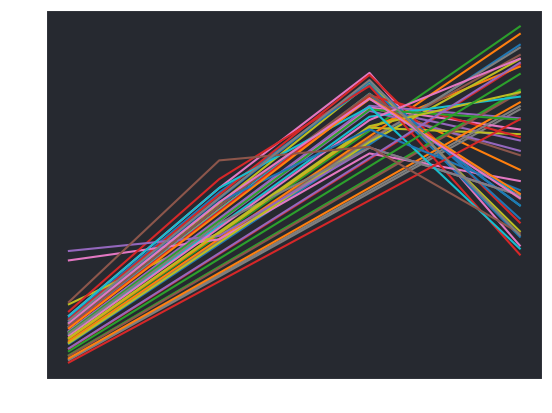

In [ ]:
fig, ax = plt.subplots()
x_data = data[0]
y_data = data[1]
labels = data[2]
sub_tables_list = list(pd.concat(data, axis=1).groupby('label'))
sub_tables_list = [x[1] for x in sub_tables_list]
for sub_table in sub_tables_list:

    line = ax.plot(sub_table[widget.x_axis_key], sub_table[widget.y_axis_key], label=sub_table['label'].values[0])

In [ ]:
list(sub_table.groupby('label'))[0]

(1,
      frame  intensity_mean  label
 0        1           50.25      1
 48       2          100.50      1
 96       3          150.75      1
 144      4          201.00      1)